In [129]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

In [130]:
def preprocess_data(df, dropna=True, drop_columns=[]):
    if dropna:
        df = df.dropna()
    df = pd.get_dummies(df, drop_first=True)
    df = df.drop(columns=drop_columns)
    return df

def create_pipeline(estimator):
    steps = []
    steps.append(('scaler', StandardScaler()))
    steps.append(('estimator', estimator))
    pipeline = Pipeline(steps)
    return pipeline

def perform_grid_search(X_train, y_train, estimator, param_grid, cv_strategy, detailed_results_file):
    pipeline = create_pipeline(estimator)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='f1', n_jobs=-1, return_train_score=False)
    # grid_search = RandomizedSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='f1', n_jobs=-1, return_train_score=False)
    grid_search.fit(X_train, y_train)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # # Save the summary results to a CSV file
    # summary_results = results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    # summary_results.to_csv(summary_results_file, index=False)
    
    # Extract only the detailed results for the best parameter set
    columns_to_keep = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    columns_to_keep.extend([key for key in grid_search.cv_results_ if key.startswith('split')])
    results_filtered = results[columns_to_keep]
    
    results_filtered.to_csv(detailed_results_file, index=False)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    return f1


param_grid_rfc = {
    'estimator__n_estimators': [100, 200, 300, 500, 1000],  # Number of trees in the forest
    'estimator__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'estimator__max_depth': [10, 20, 30, 40, 50, None],  # Maximum number of levels in tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'estimator__criterion': ['gini', 'entropy', 'log_loss'] # Method of selecting samples for training each tree
}

param_grid_lda = {
    # 'estimator__solver': ['svd', 'lsqr', 'eigen'],
    # 'estimator__n_components': [1, 2, 3, ...], # Uncomment if dimensionality reduction is needed
    # Shrinkage can only be used with the 'lsqr' and 'eigen' solvers
    'estimator__shrinkage': [None, 'auto', 0.99, 0.8, 0.6, 0.4, 0.2, 0.01]  # or a list np.linspace(0, 1, num=10)
}

param_grid_qda = {
    'estimator__reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Regularization parameter
}

param_grid_lr = [
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['newton-cg', 'lbfgs', 'sag'], 'estimator__penalty': ['l2', 'none'], 'estimator__max_iter': [100, 200, 300]},
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['liblinear'], 'estimator__penalty': ['l1', 'l2'], 'estimator__max_iter': [100, 200, 300]},
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['saga'], 'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'], 'estimator__max_iter': [100, 200, 300]}
]

param_grid_dtr = {
    'estimator__max_depth': [None, 10, 20, 30, 40, 50],
    'estimator__min_samples_split': [2, 5, 10, 20],
    'estimator__min_samples_leaf': [1, 2, 4, 10],
    'estimator__max_features': ['auto', 'sqrt', 'log2', None],
    'estimator__criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'estimator__n_neighbors': [3, 5, 7, 10, 15],
    'estimator__weights': ['uniform', 'distance'],
    # 'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__p': [1, 2, 3]  # Typically, 1 (Manhattan) or 2 (Euclidean) are used, but you can explore others
}


# Define your estimators and their parameter grids
estimators_and_parameters = {
    'LDA': (LDA(), param_grid_lda),
    'QDA': (QDA(), param_grid_qda),
    'LR': (LogisticRegression(), param_grid_lr),
    'DTR': (DecisionTreeClassifier(), param_grid_dtr),
    'KNN': (KNeighborsClassifier(), param_grid_knn),
    # 'SVM': (SVC(), param_grid_svm),
    'RFC': (RandomForestClassifier(), param_grid_rfc)
}

df = pd.read_csv('data_preprocessed.csv')
df_processed = preprocess_data(df, drop_columns=['relationship_Wife'])

# Split dataset into training and test data
X = df_processed.drop('income_>50K', axis=1)
y = df_processed['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Search for the best model and parameters for each estimator
#best_models = {}
#best_parameters = {}
#for name, (estimator, param_grid) in estimators_and_parameters.items():
#    detailed_results_file = f'{name}_grid_search_detailed.csv'
#    best_model, best_params, best_score = perform_grid_search(
#        X_train, y_train, estimator, param_grid, cv_strategy, detailed_results_file)
#    best_models[name] = best_model
#    best_parameters[name] = best_params
#    print(f"Best F1 score for {name}: {best_score}")
#    print(f"Best parameters for {name}: {best_params}")



In [131]:

def load_and_display_top_params(model_name, scaler):
    # Construct the file name based on the provided model name
    file_name = f"{scaler}/{model_name}_grid_search_detailed.csv"
    
    # Load the data from CSV file
    results = pd.read_csv(file_name)
    
    # Drop rows with NaN values
    results.dropna(inplace=True)
    
    # Sort the results by the rank of the test scores
    results_sorted = results.sort_values(by='rank_test_score')
    
    # Extract the top three sets of parameters
    top_three_params = results_sorted.head(3)
    
    # Display the top three best sets of parameters
    print("Top three best sets of parameters:")
    for index, row in top_three_params.iterrows():
       # print(f"Rank {row['rank_test_score']}: {row['params']}, Mean Score: {row['mean_test_score']}, Std Dev: {row['std_test_score']}")
        pass
    return top_three_params

def get_cv_results_for_best_params(model_name, scaler):
    # Load the data and get the top three best parameter sets
    top_params = load_and_display_top_params(model_name, scaler)
    
    # Extract the best parameter set (the first row in the sorted dataframe)
    best_params_row = top_params.iloc[0]
    
    # Get all columns that contain individual CV results
    cv_score_columns = [col for col in best_params_row.index if col.startswith('split')]
    
    # Extract these scores
    cv_scores = best_params_row[cv_score_columns]
    
    import ast
    best_params_dict = ast.literal_eval(best_params_row['params'])
    

    return cv_scores.to_list(), best_params_dict

cv_results_min_max={}
cv_results_standard={}
best_params_min_max={}
best_params_standard={}
for name in estimators_and_parameters.keys():
    print(name)
    cv_results_min_max[name], best_params_min_max[name] = get_cv_results_for_best_params(name, scaler='MinMaxResults')
    cv_results_standard[name], best_params_standard[name] = get_cv_results_for_best_params(name, scaler='ScalerResults')
    print()


LDA
Top three best sets of parameters:
Top three best sets of parameters:

QDA
Top three best sets of parameters:
Top three best sets of parameters:

LR
Top three best sets of parameters:
Top three best sets of parameters:

DTR
Top three best sets of parameters:
Top three best sets of parameters:

KNN
Top three best sets of parameters:
Top three best sets of parameters:

RFC
Top three best sets of parameters:
Top three best sets of parameters:



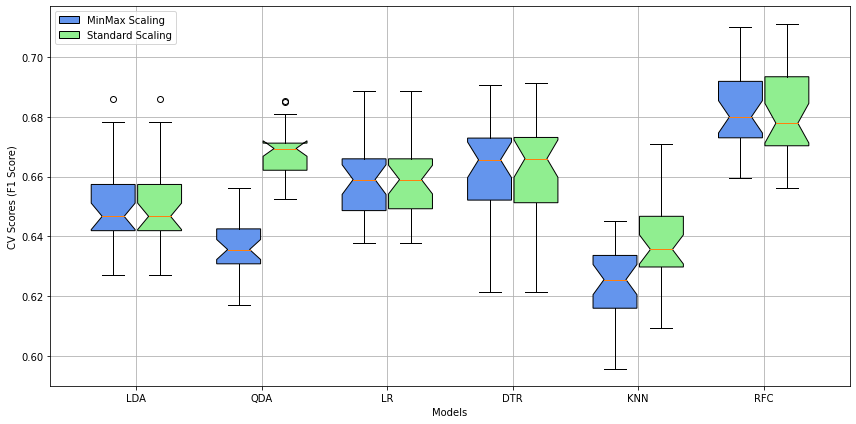

In [139]:
import matplotlib.pyplot as plt

def plot_cv_results(cv_results_min_max, cv_results_standard):
    fig, ax = plt.subplots(figsize=(12, 6))
    model_names = list(cv_results_min_max.keys())
    # Prepare data for plotting
    data_min_max = [cv_results_min_max[model] for model in model_names]
    data_standard = [cv_results_standard[model] for model in model_names]
    n_models = len(model_names)
    r = np.arange(n_models)
    width = 0.35
    

    # Create boxplots for each scaling method
    bplot1 = ax.boxplot(data_min_max, positions=r-width/2-0.01, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='cornflowerblue'),
                        notch=True, labels=model_names)

    bplot2 = ax.boxplot(data_standard, positions=r+width/2+0.01, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='lightgreen'),
                        notch=True, labels=[name + '\nStandard' for name in model_names])

    # Add title and labels
    # ax.set_title('Cross-Validation Score Comparison Among Models')
    ax.set_ylabel('CV Scores (F1 Score)')
    ax.set_xlabel('Models')

    # Customize x-axis labels
    plt.xticks([x  for x in r], model_names)

    # Adding a custom legend
    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['MinMax Scaling', 'Standard Scaling'])

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/cv_scaling_boxplots.pdf')
    plt.show()


plot_cv_results(cv_results_min_max, cv_results_standard)


In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_confusion_metrics(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_test == 1) & (y_pred == 1))
    
    FP = np.sum((y_test == 0) & (y_pred == 1))
    
    TN = np.sum((y_test == 0) & (y_pred == 0))
    
    FN = np.sum((y_test == 1) & (y_pred == 0))
    
    return {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

def create_model(model_name, params):
    # Remove the 'estimator__' prefix and instantiate models
    cleaned_params = {k.replace('estimator__', ''): v for k, v in params.items()}
    
    if model_name == 'LDA':
        return LDA(**cleaned_params)
    elif model_name == 'QDA':
        return QDA(**cleaned_params)
    elif model_name == 'LR':
        return LogisticRegression(**cleaned_params)
    elif model_name == 'DTR':
        return DecisionTreeClassifier(**cleaned_params)
    elif model_name == 'KNN':
        return KNeighborsClassifier(**cleaned_params)
    elif model_name == 'RFC':
        return RandomForestClassifier(**cleaned_params)
    else:
        raise ValueError("Unknown model name provided")

def calculate_metrics(best_params, X_train, y_train, X_test, y_test):
    results = {}
    results_CM = {}
    for model_name, params in best_params.items():
        # Instantiate the model with the provided parameters
        estimator = create_model(model_name, params)
        
        pipeline = create_pipeline(estimator)
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_precision = precision_score(y_train, y_pred_train, average='binary', zero_division=0)
        train_recall = recall_score(y_train, y_pred_train, average='binary', zero_division=0)
        train_f1 = f1_score(y_train, y_pred_train, average='binary', zero_division=0)
        
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test, average='binary', zero_division=0)
        test_recall = recall_score(y_test, y_pred_test, average='binary', zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average='binary', zero_division=0)
        
        results_CM[model_name] = calculate_confusion_metrics(y_test, y_pred_test)

    
        # Store in results
        results[model_name] = {
            'train': {
                'accuracy': train_accuracy,
                'precision': train_precision,
                'recall': train_recall,
                'f1': train_f1
            },
            'test': {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1
            }
        }
    return results, results_CM


In [134]:
# Assuming the function and models are correctly defined
metrics_results, cm_results = calculate_metrics(best_params_standard, X_train, y_train, X_test, y_test)

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


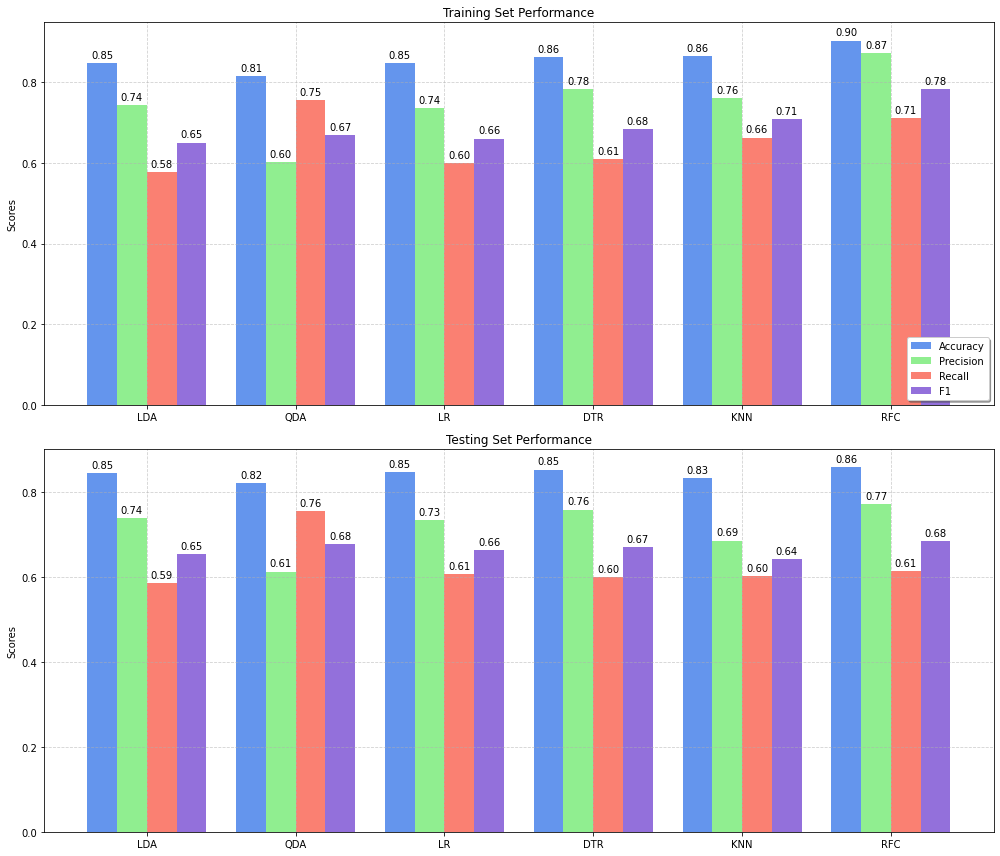

In [135]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(metric_dict):
    labels = list(metric_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    train_scores = {metric: [metric_dict[model]['train'][metric] for model in labels] for metric in metrics}
    test_scores = {metric: [metric_dict[model]['test'][metric] for model in labels] for metric in metrics}

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, axs = plt.subplots(2, figsize=(14, 12))  # Create two subplots vertically

    # Colors for the bars
    colors = ['cornflowerblue', 'lightgreen', 'salmon', 'mediumpurple']

    # Plot for training set
    for i, metric in enumerate(metrics):
        bars = axs[0].bar(x + i*width, train_scores[metric], width, label=metric.capitalize(), color=colors[i])
        axs[0].bar_label(bars, padding=3, fmt='%.2f')
    axs[0].set_ylabel('Scores')
    axs[0].set_title('Training Set Performance')
    axs[0].set_xticks(x + width * 1.5)
    axs[0].set_xticklabels(labels)
    axs[0].legend(loc='lower right', shadow=True)
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Plot for testing set
    for i, metric in enumerate(metrics):
        bars = axs[1].bar(x + i*width, test_scores[metric], width, label=metric.capitalize(), color=colors[i])
        axs[1].bar_label(bars, padding=3, fmt='%.2f')
    axs[1].set_ylabel('Scores')
    axs[1].set_title('Testing Set Performance')
    axs[1].set_xticks(x + width * 1.5)
    axs[1].set_xticklabels(labels)
    # axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig('plots/train_test_performance.pdf')
    plt.show()


plot_model_performance(metrics_results)


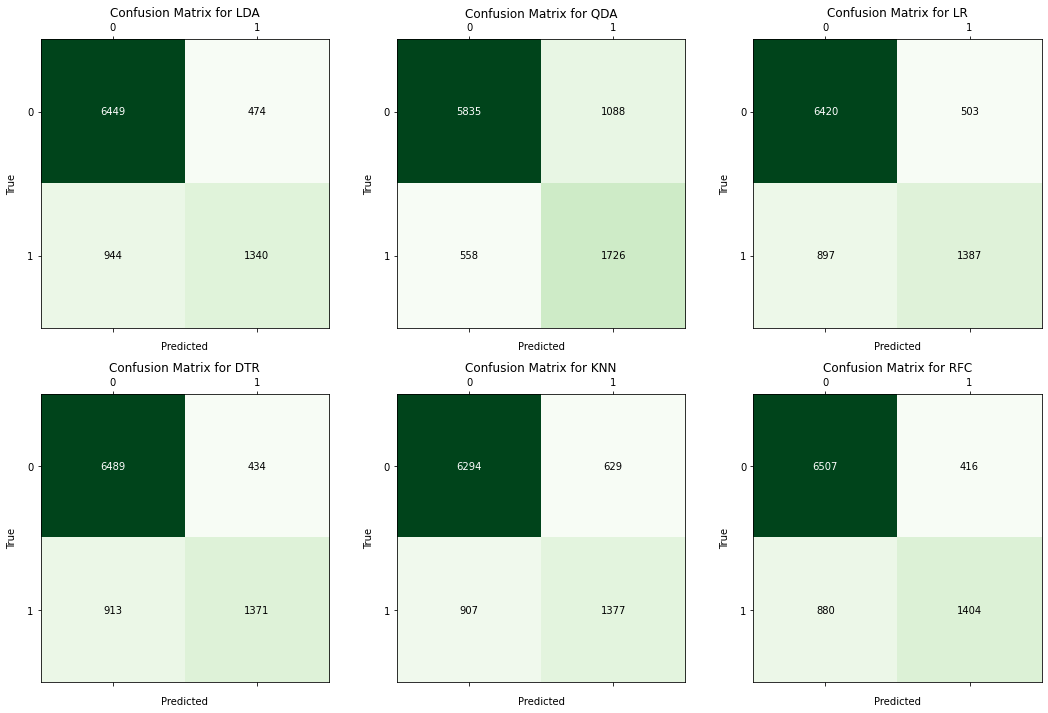

In [136]:
def plot_confusion_matrices(model_metrics):
    n_models = len(model_metrics)
    n_cols = 3
    n_rows = (n_models + 2) // n_cols  # Ensure enough rows are available
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case of multiple rows to ease indexing

    labels = ['0', '1']  # Generic labels for confusion matrix axes
    
    for ax, (model_name, metrics) in zip(axes, model_metrics.items()):
        # Convert metrics into confusion matrix format
        cm = np.array([[metrics['TN'], metrics['FP']], [metrics['FN'], metrics['TP']]])
        
        # Plot confusion matrix
        cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
        # fig.colorbar(cax, ax=ax)
        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Predicted', labelpad=10)
        ax.set_ylabel('True', labelpad=10)
        
        # Annotate confusion matrix with text
        thresh = np.max(cm) / 2.
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, format(cm[i][j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")

    # Hide any unused axes if the number of models is less than the number of subplots
    for i in range(len(model_metrics), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig('plots/confusion_matrices.pdf')
    plt.show()

plot_confusion_matrices(cm_results)

In [123]:
from sklearn.model_selection import cross_val_score

features_ordered = [
    'relationship', 
    'marital-status',
    'occupation',
    'education',      
    'age',
    'sex',
    'hours-per-week',
    'workclass', 
    'race',
    'native-country',    
    'fnlwgt',
    'capital-loss',
    'capital-gain'
    ]

rfc_best_params = best_params_standard['RFC']
rfc_best_params = {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()}

In [124]:
from tqdm import tqdm

def select_columns(data, prefixes):
    selected_columns = data.columns[data.columns.to_series().str.startswith(tuple(prefixes))]
    return data[selected_columns]

def incremental_feature_training(X_train, y_train, features_ordered, best_params):
    results = {}
    feature_set = []

    for feature in tqdm(features_ordered):
        feature_set.append(feature)
        estimator = RandomForestClassifier(**best_params)
        pipeline = create_pipeline(estimator)
        results[len(feature_set)] = cross_val_score(pipeline, select_columns(X_train, feature_set), y_train, scoring='f1', cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2))
   
    return results


In [125]:
features_scores = incremental_feature_training(X_train, y_train, features_ordered, rfc_best_params)

100%|██████████| 13/13 [38:43<00:00, 178.72s/it]


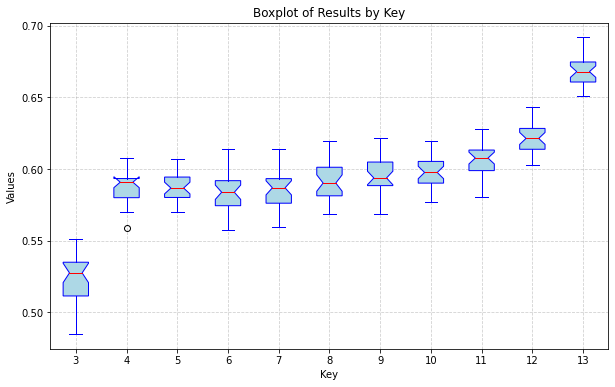

In [128]:
import matplotlib.pyplot as plt
def plot_results(data):
    plt.figure(figsize=(10, 6))
    
    # Extract the labels and values
    labels = list(data.keys())[2:]
    values = [data[key] for key in labels]

    # Create boxplots
    plt.boxplot(values, labels=labels, notch=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                medianprops=dict(color='red'))

    # Set title and labels
    plt.title('Boxplot of Results by Key')
    plt.xlabel('Key')
    plt.ylabel('Values')

    # Adding grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()
    

plot_results(features_scores)

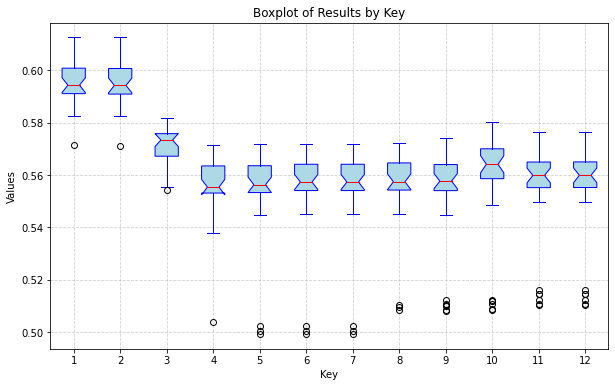

In [66]:
plot_results(features_scores_qda)

In [140]:
qda_iv = {1: np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: np.array([0.59576079, 0.59012629, 0.59674923, 0.59938838, 0.59101295,
        0.59545455, 0.60343482, 0.58974359, 0.58905704, 0.60061209,
        0.58891455, 0.59961612, 0.59716366, 0.58942457, 0.60397554,
        0.59808795, 0.60260337, 0.60038685, 0.59111446, 0.57984496,
        0.60866203, 0.59084084, 0.59526581, 0.59746251, 0.58899431,
        0.5962877 , 0.59567901, 0.59377373, 0.5975465 , 0.58730159]),
 3: np.array([0.62993492, 0.61565217, 0.63527321, 0.63926541, 0.61498708,
        0.61617458, 0.63035714, 0.61641392, 0.61968085, 0.62390925,
        0.61803714, 0.63372345, 0.62891986, 0.61593235, 0.63459038,
        0.61692845, 0.63982495, 0.62971175, 0.61890375, 0.60424028,
        0.63065437, 0.61453464, 0.6254386 , 0.62758925, 0.62191425,
        0.61852016, 0.63416776, 0.62195122, 0.63366337, 0.61236934]),
 4: np.array([0.63961814, 0.64197531, 0.63961353, 0.65825243, 0.62045889,
        0.63227638, 0.65461651, 0.62718447, 0.63331714, 0.63304515,
        0.6321499 , 0.6493756 , 0.64098906, 0.62937743, 0.64756447,
        0.63705826, 0.65076336, 0.64737096, 0.62302914, 0.62295082,
        0.64497329, 0.64133017, 0.64475592, 0.64413327, 0.62124821,
        0.62715105, 0.63640753, 0.64760058, 0.63386397, 0.63605607]),
 5: np.array([0.65190768, 0.65056818, 0.64590321, 0.66602595, 0.62838159,
        0.64983637, 0.66212931, 0.63996139, 0.65156627, 0.63588767,
        0.65107212, 0.65973535, 0.64969354, 0.64361191, 0.64997593,
        0.643026  , 0.65912306, 0.64722753, 0.62881679, 0.64316755,
        0.65575349, 0.64228786, 0.66086115, 0.65416065, 0.62699157,
        0.64046021, 0.64605138, 0.65454545, 0.65617549, 0.64599237]),
 6: np.array([0.65520446, 0.64736105, 0.64941176, 0.66981578, 0.63226406,
        0.64539991, 0.65867689, 0.6368396 , 0.65078609, 0.63932107,
        0.64509899, 0.65861588, 0.65429234, 0.64136622, 0.6573165 ,
        0.64428904, 0.65023256, 0.65538317, 0.63610586, 0.64095238,
        0.65723715, 0.64477336, 0.65933014, 0.64806055, 0.63888889,
        0.63481552, 0.65122873, 0.64564706, 0.65533522, 0.6463985 ]),
 7: np.array([0.65795614, 0.64993026, 0.65480094, 0.6713615 , 0.63221043,
        0.64983938, 0.66029623, 0.64064731, 0.6525224 , 0.64598025,
        0.65190178, 0.66327475, 0.6611265 , 0.64333018, 0.65610438,
        0.64659565, 0.65743306, 0.65753425, 0.63456091, 0.64225352,
        0.65444288, 0.65032377, 0.66066351, 0.64867424, 0.63992623,
        0.63932107, 0.65384615, 0.65160075, 0.66201767, 0.64988345]),
 8: np.array([0.65229616, 0.64985994, 0.64867424, 0.66729589, 0.63364486,
        0.644506  , 0.65459743, 0.6236355 , 0.64079508, 0.63913656,
        0.64742665, 0.6613806 , 0.64792627, 0.63263359, 0.6483209 ,
        0.64444444, 0.65478424, 0.65069478, 0.6294896 , 0.63883677,
        0.65118483, 0.63809967, 0.66158246, 0.64326376, 0.62880886,
        0.64221058, 0.64766355, 0.64619745, 0.66136576, 0.63917526]),
 9: np.array([0.652194  , 0.64537037, 0.64895105, 0.66697718, 0.62786434,
        0.63886343, 0.65725047, 0.625     , 0.63962704, 0.64159703,
        0.64663805, 0.66574586, 0.64716636, 0.63261481, 0.64757506,
        0.63857077, 0.64995357, 0.64877589, 0.62859796, 0.63216266,
        0.65418811, 0.64338235, 0.64619745, 0.64473684, 0.62721893,
        0.63503992, 0.64722222, 0.6461825 , 0.66020314, 0.63800277]),
 10: np.array([0.65404157, 0.64361457, 0.64895105, 0.66977177, 0.62700229,
        0.63893967, 0.65692743, 0.62629108, 0.64119292, 0.64342166,
        0.64949928, 0.66912103, 0.64778438, 0.63708547, 0.64760148,
        0.6379073 , 0.65090403, 0.64877589, 0.62875636, 0.63342567,
        0.65140187, 0.6458429 , 0.64622642, 0.64661654, 0.62880509,
        0.63606557, 0.64665127, 0.64458955, 0.66081331, 0.63959391]),
 11: np.array([0.65404157, 0.64298893, 0.6483209 , 0.66977177, 0.62797075,
        0.63864778, 0.65598492, 0.62535211, 0.64089427, 0.64372093,
        0.65047619, 0.66850829, 0.64748858, 0.63708547, 0.64790032,
        0.6379073 , 0.65025546, 0.64752941, 0.62875636, 0.63371824,
        0.65140187, 0.64492421, 0.64592174, 0.64974142, 0.62880509,
        0.63670412, 0.64754857, 0.64398882, 0.66050808, 0.63896584]),
 12: np.array([0.65046729, 0.64837209, 0.6491063 , 0.67042783, 0.63457944,
        0.64114391, 0.65590888, 0.62695035, 0.64534606, 0.64678472,
        0.65388303, 0.66573945, 0.64605445, 0.63606247, 0.65044455,
        0.64180479, 0.65225564, 0.65366318, 0.62983947, 0.6364486 ,
        0.65593942, 0.64678472, 0.65684411, 0.64485538, 0.62880886,
        0.64680851, 0.64093023, 0.64847059, 0.66075595, 0.64052288]),
 13: np.array([0.67279768, 0.66411116, 0.67091087, 0.68413392, 0.64594463,
        0.66282421, 0.67192118, 0.65631068, 0.6702544 , 0.67596154,
        0.67192896, 0.6849711 , 0.65994236, 0.65427873, 0.66634476,
        0.66634981, 0.67185979, 0.68101761, 0.65654091, 0.66472868,
        0.67250608, 0.66730677, 0.67156143, 0.66961652, 0.64940048,
        0.65850073, 0.66922708, 0.6770428 , 0.67376573, 0.66924565])}

rfc_iv = {1: np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: np.array([0.        , 0.        , 0.        , 0.00218103, 0.00217865,
        0.00218103, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00217865, 0.        , 0.        , 0.        , 0.        ]),
 3: np.array([0.59743291, 0.58803021, 0.61207412, 0.6007109 , 0.59942029,
        0.57520092, 0.59988145, 0.59250446, 0.58732057, 0.58338244,
        0.5948224 , 0.59537572, 0.60613071, 0.56201318, 0.52878179,
        0.58851114, 0.54293263, 0.59058824, 0.6048951 , 0.56714628,
        0.58900059, 0.59907834, 0.59276546, 0.59066745, 0.59320047,
        0.5764294 , 0.60638298, 0.59351032, 0.60911271, 0.58510638]),
 4: np.array([0.60521297, 0.57961783, 0.59680511, 0.60012796, 0.56799494,
        0.58505964, 0.59910199, 0.57854406, 0.57271557, 0.5752381 ,
        0.57731959, 0.57507987, 0.61065831, 0.55978975, 0.59974747,
        0.59781288, 0.58838384, 0.59961808, 0.59301587, 0.57620579,
        0.59819121, 0.57797581, 0.58726115, 0.60050891, 0.57663317,
        0.57379135, 0.58281445, 0.58778626, 0.61001902, 0.57801185]),
 5: np.array([0.61351187, 0.60095012, 0.61035758, 0.62013589, 0.60302115,
        0.5943728 , 0.61603888, 0.60624617, 0.59452736, 0.58645707,
        0.60388821, 0.59371221, 0.61729858, 0.58895706, 0.61190476,
        0.60843373, 0.6202381 , 0.61687917, 0.59975669, 0.59515152,
        0.61276596, 0.60400243, 0.61127596, 0.6031746 , 0.59012493,
        0.60277275, 0.6162928 , 0.60672783, 0.62318841, 0.59777228]),
 6: np.array([0.6043956 , 0.6       , 0.61595547, 0.6324159 , 0.60668693,
        0.60470588, 0.61678832, 0.61131611, 0.60534493, 0.59951456,
        0.6006192 , 0.60158633, 0.62462098, 0.58684864, 0.61407767,
        0.61117861, 0.61399276, 0.62148962, 0.60331085, 0.59631902,
        0.60998152, 0.60800971, 0.59927361, 0.61292308, 0.59724716,
        0.60292326, 0.61124402, 0.61388551, 0.62682927, 0.59574468]),
 7: np.array([0.62241169, 0.60766962, 0.62978723, 0.63119266, 0.61612515,
        0.5980975 , 0.633313  , 0.61519608, 0.60232132, 0.61399276,
        0.61124694, 0.60558252, 0.63038278, 0.59563863, 0.62105889,
        0.61916168, 0.61437126, 0.63349515, 0.62267546, 0.61094408,
        0.62219527, 0.62342342, 0.6111444 , 0.61039755, 0.60638298,
        0.61101028, 0.62537225, 0.62829149, 0.63068526, 0.61358025]),
 8: np.array([0.64663462, 0.61207412, 0.63669951, 0.64666258, 0.61840491,
        0.61837456, 0.63093788, 0.62822086, 0.61893204, 0.62219527,
        0.62453988, 0.62575211, 0.64366449, 0.60125786, 0.63056558,
        0.6219293 , 0.62771084, 0.65291262, 0.61519608, 0.61359461,
        0.63990268, 0.62998791, 0.61436331, 0.625     , 0.61893204,
        0.62364294, 0.63690476, 0.62430598, 0.64504284, 0.63470874]),
 9: np.array([0.64608076, 0.62114014, 0.63450835, 0.64346764, 0.61933905,
        0.6162928 , 0.63183475, 0.62899263, 0.61939394, 0.61575758,
        0.63476681, 0.6242497 , 0.64880952, 0.60514752, 0.6345575 ,
        0.625     , 0.6212304 , 0.64677223, 0.61864407, 0.61312078,
        0.63387978, 0.63063063, 0.61453879, 0.62621359, 0.61800487,
        0.62768496, 0.63761194, 0.62438424, 0.64508247, 0.63520871]),
 10: np.array([0.64726841, 0.62485207, 0.63432836, 0.64594759, 0.61916462,
        0.62329982, 0.62811929, 0.63157895, 0.6224924 , 0.61033435,
        0.63387978, 0.6231095 , 0.65157832, 0.6025    , 0.63570567,
        0.62663496, 0.62184874, 0.64520049, 0.61557178, 0.61425061,
        0.63515152, 0.62839879, 0.62077295, 0.62933658, 0.61276596,
        0.62938727, 0.62829736, 0.62684729, 0.63995068, 0.63636364]),
 11: np.array([0.6377858 , 0.61944778, 0.63      , 0.65036675, 0.62971985,
        0.62373286, 0.63569682, 0.62653563, 0.61519608, 0.6110773 ,
        0.63325183, 0.61968408, 0.65163205, 0.59924147, 0.62735562,
        0.62318841, 0.63234403, 0.64453832, 0.61989018, 0.60778258,
        0.62818955, 0.63543544, 0.61500615, 0.63260341, 0.61304083,
        0.6344086 , 0.64354067, 0.62274705, 0.64583333, 0.631062  ]),
 12: np.array([0.6558753 , 0.63680387, 0.64451411, 0.65765212, 0.63546798,
        0.63900415, 0.64630422, 0.6325524 , 0.62285012, 0.62393162,
        0.63641937, 0.64363636, 0.65940714, 0.61982434, 0.63357843,
        0.63745498, 0.643944  , 0.65368229, 0.62415696, 0.62081784,
        0.63125763, 0.64766525, 0.63435583, 0.64716636, 0.62393162,
        0.64698795, 0.63762855, 0.64040025, 0.65386997, 0.63574521]),
 13: np.array([0.69722557, 0.691702  , 0.68335419, 0.68150897, 0.68179031,
        0.67464115, 0.67329193, 0.68298654, 0.67848411, 0.66666667,
        0.67446154, 0.67965895, 0.69523235, 0.66413662, 0.68550369,
        0.68787515, 0.69212121, 0.69007264, 0.66461916, 0.6703163 ,
        0.68408262, 0.69053398, 0.66790582, 0.68372943, 0.67353119,
        0.67718447, 0.66990881, 0.68404718, 0.69876543, 0.68307692])}

In [157]:
def plot_iv_results(cv_results_min_max, cv_results_standard):
    fig, ax = plt.subplots(figsize=(12, 6))
    model_names = list(cv_results_min_max.keys())[2:]
    # Prepare data for plotting
    data_min_max = [cv_results_min_max[model] for model in model_names]
    data_standard = [cv_results_standard[model] for model in model_names]
    n_models = len(model_names)
    r = np.arange(n_models)
    width = 0.35
    

    # Create boxplots for each scaling method
    bplot1 = ax.boxplot(data_min_max, positions=r-width/2-0.01, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='cornflowerblue'),
                        notch=True, labels=model_names)

    bplot2 = ax.boxplot(data_standard, positions=r+width/2+0.01, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='lightgreen'),
                        notch=True, labels=[str(name) + '\nStandard' for name in model_names])

    # Add title and labels
    # ax.set_title('Cross-Validation Score Comparison Among Models')
    ax.set_ylabel('CV Scores (F1 Score)')
    ax.set_xlabel('Number of selected features according to the order obtained from Information Value')

    # Customize x-axis labels
    plt.xticks([x  for x in r], model_names)

    # Adding a custom legend
    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['QDA', 'RFC'])

    # Display the plot
    plt.grid(True)
    # plt.ylim(0.5, 0.7)
    plt.tight_layout()
    plt.savefig('plots/cv_iv_boxplots_closer.pdf')
    plt.show()

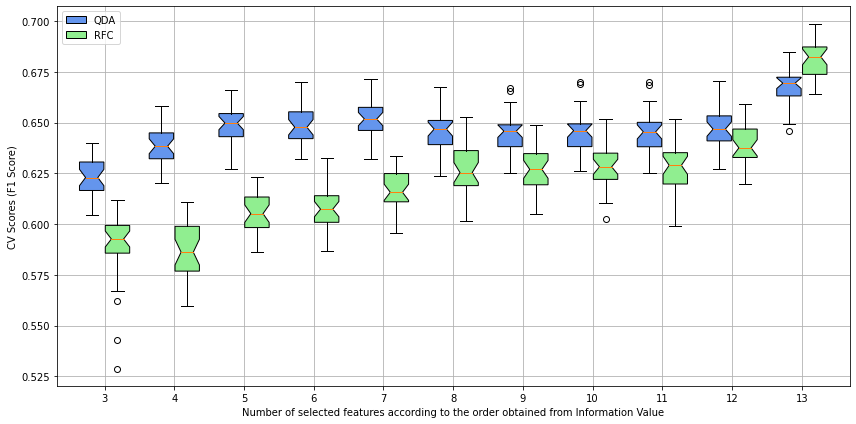

In [158]:
plot_iv_results(qda_iv, rfc_iv)

In [138]:
rfc_best_params = best_params_standard['LDA']
print('LDA', {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()})

rfc_best_params = best_params_standard['QDA']
print('QDA', {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()})

rfc_best_params = best_params_standard['LR']
print('LR', {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()})

rfc_best_params = best_params_standard['DTR']
print('DTR', {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()})

rfc_best_params = best_params_standard['KNN']
print('KNN', {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()})

rfc_best_params = best_params_standard['RFC']
print('RFC', {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()})

LDA {'shrinkage': None}
QDA {'reg_param': 0.9}
LR {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
DTR {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
KNN {'n_neighbors': 9, 'weights': 'uniform'}
RFC {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
